In [2]:
import glob
import dgl
import torch
from matplotlib import pyplot as plt
from dgl.data import DGLDataset
from global_graph_constuction import extract_all_global_graph_feature
from VGAE_train import extract_all_local_feature
from sklearn.metrics import confusion_matrix
from loading_brain_region_data import loading_label

class MyDataset(DGLDataset):
    def __init__(self,
                 url=None,
                 raw_dir=None,
                 save_dir=None,
                 force_reload=False,
                 verbose=False):
        super(MyDataset, self).__init__(name='dataset_name',
                                        url=url,
                                        raw_dir=raw_dir,
                                        save_dir=save_dir,
                                        force_reload=force_reload,
                                        verbose=verbose)

    def process(self):
        # local_feature_dict = extract_all_local_feature()
        global_graph_dict = extract_all_global_graph_feature()
        # print(global_graph_dict)
        self.graphs = []
        self.labels = []
        sub_info = loading_label()
        for sub_path in glob.glob('D:/Down/Output/subjects/*'):
            roi_signal = global_graph_dict[sub_path.split('\\')[1]][0]
            roi_signal[abs(roi_signal) < threshold] = 0
            ndata = roi_signal
            src = []
            dst = []
            edata = []
            r, w = roi_signal.shape
            for i in range(r):
                for j in range(w):
                    if roi_signal[i, j] > 0:
                        src.append(i)
                        dst.append(j)
                        edata.append([roi_signal[i, j]])
            # print(file_idx)
            graph = dgl.graph((src, dst))
            r, w = roi_signal.shape
            graph.edata['w'] = torch.tensor(edata).float()
            graph.ndata['w'] = torch.tensor(ndata[0:graph.num_nodes(), :]).float()

            self.graphs.append(graph)

            if sub_info[sub_path.split('\\')[1]] == "MCI": self.labels.append(torch.tensor(int(1)))
            else: self.labels.append(torch.tensor(int(0)))
            # print(torch.tensor(int(local_feature_dict[sub_path][1])))

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


threshold = 0.8
dataset = MyDataset()
print('Loading finished!')

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loading finished!


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling, MaxPooling


class ApplyNodeFunc(nn.Module):
    """Update the node feature hv with MLP, BN and ReLU."""
    def __init__(self, mlp):
        super(ApplyNodeFunc, self).__init__()
        self.mlp = mlp
        self.bn = nn.BatchNorm1d(self.mlp.output_dim)

    def forward(self, h):
        h = self.mlp(h)
        h = self.bn(h)
        h = F.relu(h)
        return h


class MLP(nn.Module):
    """MLP with linear output"""
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers
        self.output_dim = output_dim

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            for layer in range(num_layers - 1):
                self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for i in range(self.num_layers - 1):
                h = F.relu(self.batch_norms[i](self.linears[i](h)))
            return self.linears[-1](h)

class GIN(nn.Module):
    """GIN model"""
    def __init__(self, num_layers, num_mlp_layers, input_dim, hidden_dim,
                 output_dim, final_dropout, learn_eps, graph_pooling_type,
                 neighbor_pooling_type):

        super(GIN, self).__init__()
        self.num_layers = num_layers
        self.learn_eps = learn_eps

        # List of MLPs
        self.ginlayers = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for layer in range(self.num_layers - 1):
            if layer == 0:
                mlp = MLP(num_mlp_layers, input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(num_mlp_layers, hidden_dim, hidden_dim, hidden_dim)

            self.ginlayers.append(
                GINConv(ApplyNodeFunc(mlp), neighbor_pooling_type, 0, self.learn_eps))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Linear function for graph poolings of output of each layer
        # which maps the output of different layers into a prediction score
        self.linears_prediction = torch.nn.ModuleList()

        for layer in range(num_layers):
            if layer == 0:
                self.linears_prediction.append(
                    nn.Linear(input_dim, output_dim))
            else:
                self.linears_prediction.append(
                    nn.Linear(hidden_dim, output_dim))

        self.drop = nn.Dropout(final_dropout)

        if graph_pooling_type == 'sum':
            self.pool = SumPooling()
        elif graph_pooling_type == 'mean':
            self.pool = AvgPooling()
        elif graph_pooling_type == 'max':
            self.pool = MaxPooling()
        else:
            raise NotImplementedError

    def forward(self, g, h):
        # list of hidden representation at each layer (including input)
        hidden_rep = [h]

        for i in range(self.num_layers - 1):
            h = self.ginlayers[i](g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)

        score_over_layer = 0

        # perform pooling over all nodes in each graph in every layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linears_prediction[i](pooled_h))

        return score_over_layer

In [5]:
import math
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
import dgl
from dgl.dataloading import GraphDataLoader


class GINDataLoader():
    def __init__(self,
                 dataset,
                 batch_size,
                 device,
                 collate_fn=None,
                 seed=0,
                 shuffle=True,
                 split_name='rand',
                 fold_idx=0,
                 split_ratio=0.7):

        self.shuffle = shuffle
        self.seed = seed
        self.kwargs = {'pin_memory': True} if 'cuda' in device.type else {}

        labels = [l for _, l in dataset]

        if split_name == 'fold10':
            train_idx, valid_idx = self._split_fold10(
                labels, fold_idx, seed, shuffle)
        elif split_name == 'rand':
            train_idx, valid_idx,test_idx = self._split_rand(
                labels, split_ratio, seed, shuffle)
            test_sampler = SubsetRandomSampler(test_idx)
            self.test_loader = GraphDataLoader(
                dataset, sampler=test_sampler,
                batch_size=batch_size, collate_fn=collate_fn, **self.kwargs)
        else:
            raise NotImplementedError()

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)


        self.train_loader = GraphDataLoader(
            dataset, sampler=train_sampler,
            batch_size=batch_size, collate_fn=collate_fn, **self.kwargs)
        self.valid_loader = GraphDataLoader(
            dataset, sampler=valid_sampler,
            batch_size=batch_size, collate_fn=collate_fn, **self.kwargs)


    def train_valid_loader(self):
        return self.train_loader, self.valid_loader, self.test_loader
#         return self.train_loader, self.valid_loader

    def _split_fold10(self, labels, fold_idx=0, seed=0, shuffle=True):
        ''' 10 flod '''
        assert 0 <= fold_idx and fold_idx < 10, print(
            "fold_idx must be from 0 to 9.")

        skf = StratifiedKFold(n_splits=10, shuffle=shuffle, random_state=seed)
        idx_list = []
        for idx in skf.split(np.zeros(len(labels)), labels):    # split(x, y)
            idx_list.append(idx)
        train_idx, valid_idx = idx_list[fold_idx]

        print(
            "train_set : test_set = %d : %d",
            len(train_idx), len(valid_idx))

        return train_idx, valid_idx

    def _split_rand(self, labels, split_ratio=0.7, seed=0, shuffle=True):
        num_entries = len(labels)
        indices = list(range(num_entries))
        np.random.seed(seed)
        np.random.shuffle(indices)
        split = int(math.floor(split_ratio * num_entries))
        test_split = int(math.floor(0.9 * num_entries))
#         添加test_idx
        train_idx, valid_idx, test_idx = indices[:split], indices[split:test_split], indices[test_split:]

        print(
            "train_set : test_set = %d : %d",
            len(train_idx), len(valid_idx))

        return train_idx, valid_idx,test_idx

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 1  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%
epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%
epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%
epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%
epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%
epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%
epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%
epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%
epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%
epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%
epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%
epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%
epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%
epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%
epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%
epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%
epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


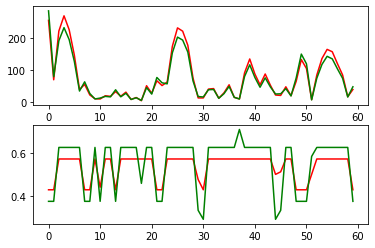

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 2  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%
epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%
epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%
epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%
epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%
epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%
epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%
epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%
epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%
epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%
epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%
epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%
epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%
epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%
epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%
epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%
epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%
epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


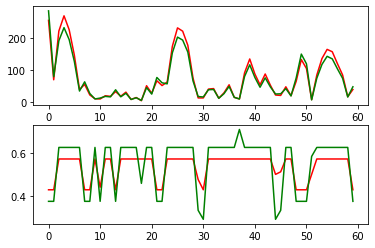

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 3  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%
epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%
epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%
epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%
epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%
epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%
epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%
epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%
epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%
epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%
epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%
epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%
epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%
epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%
epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%
epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%
epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%
epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%
epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


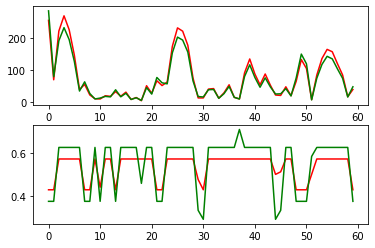

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 4  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%
epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%
epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%
epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%
epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%
epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%
epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%
epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%
epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%
epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%
epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%
epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%
epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%
epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%
epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%
epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%
epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%
epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%
epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%
epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%
epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%
epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%
epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%
epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


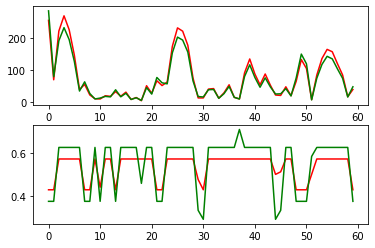

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 5  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%
epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%
epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%
epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%
epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%
epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%
epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%
epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%

C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%
epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%
epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%
epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%
epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%
epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%
epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%
epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%
epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%
epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


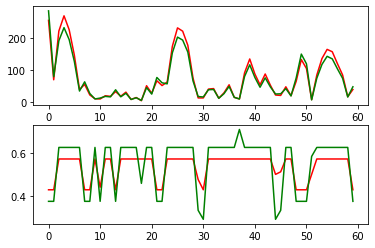

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 6  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%

C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%
epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%
epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%
epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%
epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%
epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%
epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%
epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%
epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%
epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%
epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%
epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%
epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%
epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%
epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%
epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%
epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%
epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%
epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%
epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%
epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%
epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%
epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%
epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%
epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


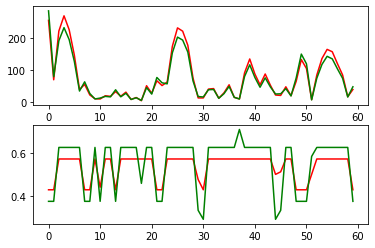

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 7  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%
epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%
epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%
epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%
epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%
epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%
epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%
epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%
epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%
epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%
epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%
epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%
epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%
epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%
epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%
epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%
epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


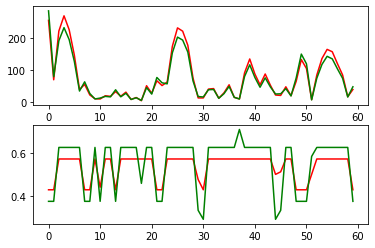

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 8  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

test loss: 199.0114, accuracy: 61.54%
epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%
epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%
epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%
epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%
epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%
epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%
epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%
epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%
epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%
epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%
epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%
epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%
epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%
epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%
epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%
epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%
epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%
epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%
epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


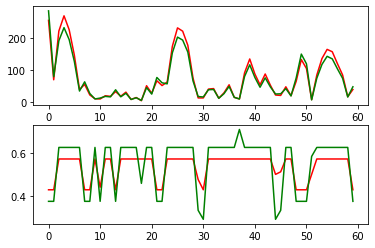

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 9  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%
epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%
epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%
epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%
epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%
epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%
epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%
epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%
epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%
epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%
epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%
epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%
epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 47, train loss: 47.5098, accuracy: 57.14%		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%
epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%
epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%
epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%
epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%
epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


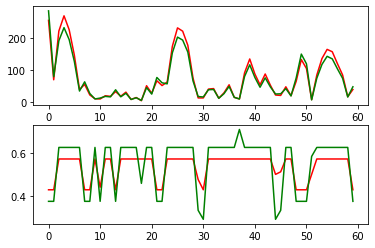

Loading global graph data!


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is No. 10  turn
train_set : test_set = %d : %d 84 24
epoch: 1, train loss: 253.9439, accuracy: 42.86%		valid loss: 283.5758, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 269.5931, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 2, train loss: 69.3024, accuracy: 42.86%		valid loss: 78.9189, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 74.9339, accuracy: 38.46%
epoch: 3, train loss: 220.8050, accuracy: 57.14%		valid loss: 190.7002, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 195.5793, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 4, train loss: 268.1079, accuracy: 57.14%		valid loss: 231.4193, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 236.4639, accuracy: 61.54%
epoch: 5, train loss: 224.7540, accuracy: 57.14%		valid loss: 194.1061, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 199.0114, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 6, train loss: 146.0562, accuracy: 57.14%		valid loss: 126.3744, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 131.0162, accuracy: 61.54%
epoch: 7, train loss: 39.0404, accuracy: 57.14%		valid loss: 34.2725, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 38.5541, accuracy: 61.54%
epoch: 8, train loss: 54.8055, accuracy: 42.86%		valid loss: 62.8880, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 59.5577, accuracy: 38.46%
epoch: 9, train loss: 22.0655, accuracy: 42.86%		valid loss: 26.6419, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 24.9940, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\to

epoch: 10, train loss: 10.3258, accuracy: 57.14%		valid loss: 9.6086, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 13.8552, accuracy: 61.54%
epoch: 11, train loss: 9.5281, accuracy: 44.05%		valid loss: 12.3942, accuracy: 37.50%
valid sensitivity 97.22,specificity 4.17, precision 43.21
test loss: 12.4705, accuracy: 30.77%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 12, train loss: 19.6310, accuracy: 57.14%		valid loss: 17.6230, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 21.9471, accuracy: 61.54%
epoch: 13, train loss: 17.8028, accuracy: 57.14%		valid loss: 16.0677, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.4561, accuracy: 61.54%
epoch: 14, train loss: 32.4331, accuracy: 42.86%		valid loss: 38.2129, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 35.7446, accuracy: 38.46%
epoch: 15, train loss: 18.1299, accuracy: 57.14%		valid loss: 16.3216, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 20.9014, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 16, train loss: 30.8353, accuracy: 57.14%		valid loss: 27.3447, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 32.0306, accuracy: 61.54%
epoch: 17, train loss: 8.1008, accuracy: 57.14%		valid loss: 8.1005, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 12.1875, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 18, train loss: 14.1478, accuracy: 57.14%		valid loss: 13.3115, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.9706, accuracy: 61.54%
epoch: 19, train loss: 4.2139, accuracy: 57.14%		valid loss: 5.1111, accuracy: 45.83%
valid sensitivity 27.78,specificity 79.17, precision 50.00
test loss: 9.3239, accuracy: 53.85%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 20, train loss: 50.7695, accuracy: 57.14%		valid loss: 44.9310, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.6725, accuracy: 61.54%
epoch: 21, train loss: 27.2885, accuracy: 57.14%		valid loss: 24.7708, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 29.4093, accuracy: 61.54%
epoch: 22, train loss: 66.2539, accuracy: 42.86%		valid loss: 76.3903, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 71.1911, accuracy: 38.46%
epoch: 23, train loss: 51.2932, accuracy: 42.86%		valid loss: 59.9300, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 55.4471, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 24, train loss: 62.2906, accuracy: 57.14%		valid loss: 56.5921, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 57.8810, accuracy: 61.54%
epoch: 25, train loss: 173.2573, accuracy: 57.14%		valid loss: 153.1846, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 153.8125, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 26, train loss: 230.6169, accuracy: 57.14%		valid loss: 201.9287, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 203.2338, accuracy: 61.54%
epoch: 27, train loss: 220.3905, accuracy: 57.14%		valid loss: 192.6514, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 192.5300, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 28, train loss: 176.4721, accuracy: 57.14%		valid loss: 155.3639, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 156.4129, accuracy: 61.54%
epoch: 29, train loss: 75.2624, accuracy: 57.14%		valid loss: 65.9424, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 72.4531, accuracy: 61.54%
epoch: 30, train loss: 12.8801, accuracy: 47.62%		valid loss: 17.1476, accuracy: 33.33%
valid sensitivity 94.44,specificity 12.50, precision 44.74
test loss: 14.7681, accuracy: 23.08%
epoch: 31, train loss: 12.7657, accuracy: 42.86%		valid loss: 15.8683, accuracy: 29.17%
valid sensitivity 83.33,specificity 12.50, precision 41.67
test loss: 15.3710, accuracy: 23.08%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars


epoch: 32, train loss: 40.4114, accuracy: 57.14%		valid loss: 38.2598, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 41.5907, accuracy: 61.54%
epoch: 33, train loss: 41.8835, accuracy: 57.14%		valid loss: 39.1608, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 40.6593, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 34, train loss: 11.8252, accuracy: 57.14%		valid loss: 11.7454, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 14.7284, accuracy: 61.54%
epoch: 35, train loss: 28.5343, accuracy: 57.14%		valid loss: 25.8568, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 28.0998, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 36, train loss: 53.7230, accuracy: 57.14%		valid loss: 48.4945, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 49.2181, accuracy: 61.54%
epoch: 37, train loss: 14.6689, accuracy: 57.14%		valid loss: 14.7179, accuracy: 62.50%
valid sensitivity 2.78,specificity 97.92, precision 50.00
test loss: 15.0451, accuracy: 61.54%
epoch: 38, train loss: 9.7187, accuracy: 57.14%		valid loss: 9.5620, accuracy: 70.83%
valid sensitivity 22.22,specificity 83.33, precision 50.00
test loss: 10.1560, accuracy: 61.54%
epoch: 39, train loss: 91.0305, accuracy: 57.14%		valid loss: 79.6367, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 79.3371, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warning

epoch: 40, train loss: 133.9630, accuracy: 57.14%		valid loss: 115.7881, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 115.1821, accuracy: 61.54%
epoch: 41, train loss: 87.1522, accuracy: 57.14%		valid loss: 76.4980, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 74.0751, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 42, train loss: 53.5458, accuracy: 57.14%		valid loss: 46.0319, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 44.9591, accuracy: 61.54%
epoch: 43, train loss: 87.2492, accuracy: 57.14%		valid loss: 75.2757, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.1941, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 44, train loss: 52.4745, accuracy: 57.14%		valid loss: 47.1409, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 43.5817, accuracy: 61.54%
epoch: 45, train loss: 21.8278, accuracy: 50.00%		valid loss: 25.0146, accuracy: 29.17%
valid sensitivity 91.67,specificity 18.75, precision 45.83
test loss: 29.4411, accuracy: 38.46%
epoch: 46, train loss: 20.6409, accuracy: 51.19%		valid loss: 25.6746, accuracy: 33.33%
valid sensitivity 94.44,specificity 18.75, precision 46.58
test loss: 26.4237, accuracy: 38.46%
epoch: 47, train loss: 47.5098, accuracy: 57.14%

C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


		valid loss: 41.8330, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 48.6370, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 48, train loss: 19.7281, accuracy: 57.14%		valid loss: 19.1012, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 22.2374, accuracy: 61.54%
epoch: 49, train loss: 64.2155, accuracy: 42.86%		valid loss: 74.7217, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 69.9633, accuracy: 38.46%
epoch: 50, train loss: 132.1520, accuracy: 42.86%		valid loss: 149.1862, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 140.1959, accuracy: 38.46%
epoch: 51, train loss: 104.1508, accuracy: 42.86%		valid loss: 118.8031, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 110.8203, accuracy: 38.46%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 52, train loss: 7.5039, accuracy: 50.00%		valid loss: 6.7951, accuracy: 58.33%
valid sensitivity 36.11,specificity 60.42, precision 40.62
test loss: 10.3112, accuracy: 53.85%
epoch: 53, train loss: 83.8424, accuracy: 57.14%		valid loss: 74.0013, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 76.8750, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ip

epoch: 54, train loss: 135.3017, accuracy: 57.14%		valid loss: 117.0557, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 123.9020, accuracy: 61.54%
epoch: 55, train loss: 163.7912, accuracy: 57.14%		valid loss: 142.2363, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 145.5643, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 56, train loss: 156.4241, accuracy: 57.14%		valid loss: 134.2487, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 136.7476, accuracy: 61.54%
epoch: 57, train loss: 119.4337, accuracy: 57.14%		valid loss: 103.2760, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 104.5457, accuracy: 61.54%


C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\DELL\anaconda3\envs\GIN\lib\sit

epoch: 58, train loss: 84.2972, accuracy: 57.14%		valid loss: 73.9248, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 73.1671, accuracy: 61.54%
epoch: 59, train loss: 16.5920, accuracy: 57.14%		valid loss: 15.7266, accuracy: 62.50%
valid sensitivity 0.00,specificity 100.00, precision nan
test loss: 16.4147, accuracy: 61.54%
epoch: 60, train loss: 39.0295, accuracy: 42.86%		valid loss: 47.5286, accuracy: 37.50%
valid sensitivity 100.00,specificity 0.00, precision 42.86
test loss: 46.6833, accuracy: 38.46%


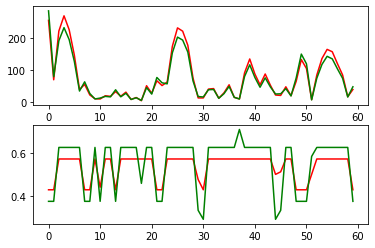

Final result: valid accuracy 37.50, valid sensitivity 100.00, valid specificity 0.00, valid precision 37.50


In [7]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


def train(args, net, trainloader, optimizer, criterion, epoch):
    net.train()

    running_loss = 0
    total_iters = len(trainloader)
    bar = list(range(total_iters))

    for pos, (graphs, labels) in zip(bar, trainloader):
        # batch graphs will be shipped to device in forward part of model
        labels = labels.to(device)
        graphs = graphs.to(device)
        feat = graphs.ndata.pop('w')
        outputs = net(graphs, feat)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    running_loss = running_loss / total_iters

    return running_loss


def eval_net(args, net, dataloader, criterion):
    net.eval()

    total = 0
    total_loss = 0
    total_correct = 0
    total_tp = 0
    total_tn = 0
    total_fp = 0
    total_fn = 0

    for data in dataloader:
        graphs, labels = data
        graphs = graphs.to(device)
        labels = labels.to(device)
        feat = graphs.ndata.pop('w')
        total += len(labels)
        outputs = net(graphs, feat)
        _, predicted = torch.max(outputs.data, 1)

        total_correct += (predicted == labels.data).sum().item()
        tn, fp, fn, tp = confusion_matrix(labels.data,predicted, labels=[0,1]).ravel()
        total_tp += tp
        total_tn += tn
        total_fp += fp
        total_fn += fn
        loss = criterion(outputs, labels)
        # crossentropy(reduce=True) for default
        total_loss += loss.item() * len(labels)

    loss, acc = 1.0*total_loss / total, 1.0*total_correct / total
    specificity = total_tn/(total_fp+total_tn)
    sensitivity = total_tp/(total_tp+total_fn)
    precision = total_tp/(total_tp+total_fp)
    net.train()

    return loss, acc, sensitivity, specificity, precision

seed = 0
batch_size = 64
device = torch.device("cpu")

num_layers = 4
num_mlp_layers = 5
dim_nfeats = 5
hidden_dim = 32
gclasses = 2
final_dropout = 0.6
learn_eps = False
graph_pooling_type = 'sum'
neighbor_pooling_type = 'sum'
lr = 0.001
epochs = 60

def main(args, fold_idx):

    torch.manual_seed(seed)
    np.random.seed(seed)


    trainloader, validloader, testloader = GINDataLoader(
        dataset, batch_size=batch_size, device=device,
        seed=seed, shuffle=True,
        split_name='rand', fold_idx=fold_idx).train_valid_loader()


    model = GIN(
        num_layers, num_mlp_layers,
        dim_nfeats, hidden_dim, gclasses,
        final_dropout,learn_eps,
        graph_pooling_type, neighbor_pooling_type).to(device)


    criterion = nn.CrossEntropyLoss()  # defaul reduce is true
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


#     for epoch, _, _ in zip(tbar, vbar, lrbar):
    train_loss_ret, train_acc_ret, train_sens_ret, train_spec_ret, train_prec_ret  = [], [], [], [], []
    val_loss_ret, val_acc_ret, val_sens_ret, val_spec_ret, val_prec_ret = [], [], [], [], []
    test_loss_ret, test_acc_ret, test_sens_ret, test_spec_ret, test_prec_ret = [], [], [], [], []
    for epoch in range(epochs):

        train(args, model, trainloader, optimizer, criterion, epoch)
        scheduler.step()

        train_loss, train_acc, train_sens, train_spec, train_precision= eval_net(
            args, model, trainloader, criterion)

        print('epoch: {}, train loss: {:.4f}, accuracy: {:.2f}%'.format(epoch+1, train_loss, 100. * train_acc), end='')
        train_loss_ret.append(train_loss)
        train_acc_ret.append(train_acc)
        train_sens_ret.append(train_sens)
        train_spec_ret.append(train_spec)
        train_prec_ret.append(train_precision)

        valid_loss, valid_acc, valid_sens, valid_spec, valid_precision = eval_net(
            args, model, validloader, criterion)
        print('\t\tvalid loss: {:.4f}, accuracy: {:.2f}%'.format(valid_loss, 100. * valid_acc))
        print('valid sensitivity {:.2f},specificity {:.2f}, precision {:.2f}'.format(100*train_sens, 100*train_spec, 100*train_precision))
        val_loss_ret.append(valid_loss)
        val_acc_ret.append(valid_acc)
        val_sens_ret.append(valid_sens)
        val_spec_ret.append(valid_spec)
        val_prec_ret.append(valid_precision)

        test_loss, test_acc, test_sens, test_spec, test_precision = eval_net(
            args, model, testloader, criterion)
        print('test loss: {:.4f}, accuracy: {:.2f}%'.format(test_loss, 100. * test_acc))
#         print('valid sensitivity {:.2f},specificity {:.2f}, precision {:.2f}'.format(100*train_sens, 100*train_spec, 100*train_precision))
        test_loss_ret.append(test_loss)
        test_acc_ret.append(test_acc)
        test_sens_ret.append(test_sens)
        test_spec_ret.append(test_spec)
        test_prec_ret.append(test_precision)

    return train_loss_ret, train_acc_ret, train_sens_ret, train_spec_ret, train_prec_ret, val_loss_ret, val_acc_ret, val_sens_ret, val_spec_ret, val_prec_ret, test_loss_ret, test_acc_ret, test_sens_ret, test_spec_ret, test_prec_ret

#save the final result
train_acc_list = []
val_acc_list = []
test_acc_list = []
train_loss_list = []
val_loss_list = []
test_loss_list = []
train_sens_list = []
val_sens_list = []
test_sens_list = []
train_spec_list = []
val_spec_list = []
test_spec_list = []
train_prec_list = []
val_prec_list = []
test_prec_list = []

if __name__ == '__main__':

    args = None
# for thres_step in range(3):
#     threshold = 0.2+thres_step*0.13

    for idx in range(10):
        threshold=0.8
        seed = 0
        dataset = MyDataset()
        print('This is No. {}  turn'.format(idx+1))
#         train_loss_ret, train_acc_ret, val_loss_ret, val_acc_ret = main(args, idx)
        train_loss_ret, train_acc_ret, train_sens_ret, train_spec_ret, train_prec_ret, val_loss_ret, val_acc_ret, val_sens_ret, val_spec_ret, val_prec_ret, test_loss_ret, test_acc_ret, test_sens_ret, test_spec_ret, test_prec_ret = main(args, idx)
        train_acc_list.append(train_acc_ret[epochs-1])
        val_acc_list.append(val_acc_ret[epochs-1])
        test_acc_list.append(test_acc_ret[epochs-1])
        train_loss_list.append(train_loss_ret[epochs-1])
        val_loss_list.append(val_loss_ret[epochs-1])
        test_loss_list.append(test_loss_ret[epochs-1])
        train_sens_list.append(train_sens_ret[epochs-1])
        val_sens_list.append(val_sens_ret[epochs-1])
        test_sens_list.append(test_sens_ret[epochs-1])
        train_spec_list.append(train_spec_ret[epochs-1])
        val_spec_list.append(val_spec_ret[epochs-1])
        test_spec_list.append(test_spec_ret[epochs-1])
        train_prec_list.append(train_prec_ret[epochs-1])
        val_prec_list.append(val_prec_ret[epochs-1])
        test_prec_list.append(test_prec_ret[epochs-1])

        plt.subplot(211)
        plt.plot(list(range(epochs)), train_loss_ret, color='r')
        plt.plot(list(range(epochs)), val_loss_ret, color='g')
        plt.subplot(212)
        plt.plot(list(range(epochs)), train_acc_ret, color='r')
        plt.plot(list(range(epochs)), val_acc_ret, color='g')
        plt.show()

    print('Final result: valid accuracy {:.2f}, valid sensitivity {:.2f}, valid specificity {:.2f}, valid precision {:.2f}'.format(10*sum(val_acc_list), 10*sum(val_sens_list), 10*sum(val_spec_list), 10*sum(val_prec_list)))